# Multi temporal evalscripts

This notebook will show you how to use evalscripts to do multi-temporal analysis. To carry out this notebook you need the following requisites:

- Basic Knowledge of Remote Sensing
    - Sensors
    - Spectral Bands
    - Indices
- Basic Familiarity with Sentinel Hub
    - Collections
    - Processing API
    - Statistical API
    - Basic understanding of evalscripts (see previous notebook)

If you are aware of the basics of all of these topics you are well equipped to tackle this notebook. 

Multi-temporal analysis is where Sentinel Hub and evalscripts really shine. Instead of having to download a lot of data to construct a cloudless mosaic or a maximum NDVI composite, all of this can be done in an evalscript, allowing you to only download the end result. To illustrate the different concepts of multi-temporal evalscripts, we will look at three use-cases:

- Cloud-free mosaic
- Maximum NDVI composite
- Temporal change detection

In [11]:
import json
from pprint import pprint

import matplotlib.pyplot as plt
from sentinelhub import (
    CRS,
    DataCollection,
    DownloadFailedException,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)

config = SHConfig()

In [12]:
def request_helper(evalscript, start_date="2023-04-01", end_date="2023-04-10"):
    aoi = Geometry(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [-52.307067, -27.262221],
                    [-52.307067, -27.238987],
                    [-52.280803, -27.238987],
                    [-52.280803, -27.262221],
                    [-52.307067, -27.262221],
                ]
            ],
        },
        CRS.WGS84,
    )
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(
                    "28eef896-9632-4546-a99e-cea34d74b21e"
                ),
                time_interval=(start_date, end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=aoi,
        size=[1000, 1000],
        config=config,
    )
    return request.get_data()

To run multi-temporal evalscripts, we need to set the `mosaicking` key in the setup function. The mosaicking options are `SIMPLE`, `ORBIT` and `TILE`.

`SIMPLE` is the default mosaicking behaviour. It will return only a single value per pixel. Depending on what is set in the request body, it will return the value of the `mostRecent`, `leastRecent` or `leastCC` tile in the requested time period. This mosaicking can not be used for multi-temporal evalscripts.

`TILE` will return all tiles in the time range. This mean that depending on your data source you can get multiple values per day, or in the case of Sentinel 2, where the tiles overlap, you can also get duplicate data.

With `ORBIT` it will carry out a `SIMPLE` mosaicking for each day in the requested time range which has tiles available. The advantage is that the input is slightly simplified for data sources where you never expect multiple recorded values per day.

```js
function setup() {
    return {
        input: ["red", "green", "blue", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}
```

In our case we will use `mosaicking: "TILE"`, since we are using Planetscope data which might return multiple unique values per day.

Now let's first use `throw new Error()` to look at how the data is structured that we get in the `evaluatePixel` function.

In [13]:
samples_evalscript = """
function setup() {
    return {
        input: ["red", "green", "blue", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    throw new Error(JSON.stringify(samples))
    return
}
"""
try:
    request_helper(samples_evalscript, start_date="2023-04-01", end_date="2023-04-10")
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    samples = json.loads(em[em.index("[") : em.index("]") + 1])
    pprint(samples)

[{'blue': 437, 'dataMask': 1, 'green': 826, 'red': 831},
 {'blue': 0, 'dataMask': 0, 'green': 0, 'red': 0},
 {'blue': 2080, 'dataMask': 1, 'green': 2146, 'red': 2246},
 {'blue': 2218, 'dataMask': 1, 'green': 2235, 'red': 2336},
 {'blue': 415, 'dataMask': 1, 'green': 772, 'red': 898},
 {'blue': 414, 'dataMask': 1, 'green': 768, 'red': 944},
 {'blue': 341, 'dataMask': 1, 'green': 663, 'red': 837},
 {'blue': 322, 'dataMask': 1, 'green': 659, 'red': 856},
 {'blue': 0, 'dataMask': 0, 'green': 0, 'red': 0},
 {'blue': 0, 'dataMask': 0, 'green': 0, 'red': 0},
 {'blue': 2199, 'dataMask': 1, 'green': 2206, 'red': 2275}]


Here we can nicely see the structure of the samples object in evaluatePixel. While for `mosaicking: "SIMPLE"` we got an object where we could access the requested bands directly (`samples.green`). We now have an array with all of the tiles in our time range. So to access values we first need to indicate from which position in the array we want the values. So to get the first value in the array we can get it with `samples[0].green`.

We can also notice that some indices (like index 1) have a dataMask of 0. This means, that for this specific pixel there is no data. This happens if a tile only partially covers the area of interest. In this case all pixels that the tile does not cover get a dataMask of 0. Because of this we always need to handle pixels with `datatMask == 0` when doing multi-temporal analysis in an evalscript.

Now this output does not tell us anything about from which dates each of the values in the array are. For this we can use the optional second parameter of `evaluatePixel` which is usually called `scenes`. When using `mosaicking: "TILE"` we need to access the property `tiles`. When using `mosaicking: "ORBIT"` we need to access the property `orbits`. More information in the [documentation](https://docs.sentinel-hub.com/api/latest/evalscript/v3/#scenes).


Let's see what this returns:

```js
function evaluatePixel(samples, scenes) {
    throw new Error(JSON.stringify(scenes.tiles))
    return
}
```

In [14]:
scenes_evalscript = """
function setup() {
    return {
        input: ["red", "green", "blue", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples, scenes) {
    throw new Error(JSON.stringify(scenes.tiles))
    return
}
"""
try:
    request_helper(scenes_evalscript, start_date="2023-04-01", end_date="2023-04-10")
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    scenes = json.loads(em[em.index("[") : em.index("]") + 1])
    pprint(scenes)

[{'__idx': 0,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230409_124434_67_24b2/20230409_124434_67_24b2_(BAND).tif',
  'date': '2023-04-09T12:44:34.676786Z',
  'shId': 17725313,
  'tileOriginalId': '03fb15c5-4b00-4057-b94b-be892549c2de'},
 {'__idx': 1,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230408_132106_91_2424/20230408_132106_91_2424_(BAND).tif',
  'date': '2023-04-08T13:21:06.919183Z',
  'shId': 17805766,
  'tileOriginalId': 'e45f6c0a-beff-4561-80a2-291975e8b5c5'},
 {'__idx': 2,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230405_133118_12_2402/20230405_133118_12_2402_(BAND).tif',
  'date': '2023-04-05T13:31:18.122270Z',
  'shId': 17733009,
  'tileOriginalId': 'd30393d1-b767-446d-ae02-935ef965c103'},
 {'__idx': 3,
  'dataP

We can see that it returns a bunch of metadata per object in the samples array. One of the returned metadata properties is the date. With this we can see that our samples data is sorted by most recent acquisition and ranges from `2023-04-09` to `2023-04-01`.

Now let's do the first analysis in the evalscript.

## Temporal Mean NDVI

To do this we loop through all of our samples in the array. Per sample we then check if it is a valid sample. In our case valid data means that the data is `clear` and the `dataMask` is 1. If it isn't we can immediately continue to the next sample.

If the sample is valid we can calculate the NDVI and sum it up. To finally calculate the mean we also need to keep track of how many samples were valid.

With multi temporal scripts it is also really important to think of **edge cases**. In this script we have to think of the case where all returned samples might be invalid. We need to handle this specific case so that the output is well defined.

```js
var NODATA = NaN;
function evaluatePixel(samples) {
    var sum = 0;
    var valid = 0;
    
    // Loop through all samples
    for(let i=0; i<samples.length; i++){
        let sample = samples[i];
        // Check if the sample is valid
        if(!sample.dataMask || !sample.clear){
            // continue to the next sample if not valid
            continue;
        }
        // calculate NDVI if sample is valid
        const ndvi = index(sample.nir, sample.red);
        // add the ndvi to the sum
        sum += ndvi;
        // increment the number of valid samples
        valid++
    }

    // Check if there is any valid samples
    if(valid==0){
        return [NODATA]
    }
    
    const mean = sum / valid
    return [mean]
}
```


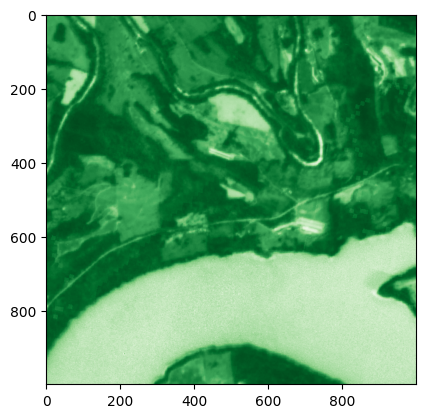

In [15]:
mean_ndvi_evalscript = """
var NODATA = NaN;

function setup() {
    return {
        input: ["red", "nir", "clear", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
            nodataValue: NODATA
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    var sum = 0;
    var valid = 0;

    // Loop through all samples
    for(let i=0; i<samples.length; i++){
        let sample = samples[i];
        // Check if the sample is valid
        if(!sample.dataMask || !sample.clear){
            // continue to the next sample if not valid
            continue;
        }
        // calculate NDVI if sample is valid
        const ndvi = index(sample.nir, sample.red);
        // add the ndvi to the sum
        sum += ndvi;
        // increment the number of valid samples
        valid++
    }

    // Check if there is any valid samples
    if(valid==0){
        return [NODATA]
    }

    const mean = sum / valid
    return [mean]
}
"""
mean_ndvi_data = request_helper(
    mean_ndvi_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(mean_ndvi_data[0], cmap="Greens");

And just like that we have calculated the mean NDVI for half a month. You can also try calculating the mean NDVI for an entire month or even a quarter or full year. Be aware though, that the Process API has a timeout which will limit very large requests. If you do run into this timeout you might want to look into the [Async Process API](https://docs.sentinel-hub.com/api/latest/api/async-process/).

## Exercise: Maximum NDVI

Now it's your turn to modify this script. The task now is to calculate the maximum NDVI over the time range. 

The basic idea stays the same:

1. Loop over all samples which are returned
2. Check if the sample is valid
3. If the sample is valid calculate NDVI
4. Check if the NDVI value is larger than the current max and if so overwrite it
5. Handle edge cases

Hint: You can initialize the variable which holds the current max with `Number.NEGATIVE_INFINITY`. This way every new NDVI value will be larger than the initilized value.

<details><summary>See solution</summary>

```js
var NODATA = NaN;

function setup() {
    return {
        input: ["red", "nir", "clear", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
            nodataValue: NODATA
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    var max = Number.NEGATIVE_INFINITY;
    
    // Loop through all samples
    for(let i=0; i<samples.length; i++){
        let sample = samples[i];
        // Check if the sample is valid
        if(!sample.dataMask || !sample.clear){
            // continue to the next sample if not valid
            continue;
        }
        // calculate NDVI if sample is valid
        const ndvi = index(sample.nir, sample.red);
        // check if ndvi is larger than current max
        if(ndvi > max){
            max = ndvi;
        }
    }

    if(max == Number.NEGATIVE_INFINITY){
        return [NODATA]
    }
    
    return [max]
}
```
</details>


In [16]:
max_ndvi_evalscript = """

"""
max_ndvi_data = request_helper(
    max_ndvi_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(max_ndvi_data[0], cmap="Greens");

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/process
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/api/v1/process
Server response: "{"status": 400, "reason": "Bad Request", "message": "Missing or empty evalscript.", "code": "RENDERER_EXCEPTION"}"

## Cloud Free True Color Mosaics

Next we want to have a look at how to construct cloud free mosaics. The same general concept as before applies. However now instead of doing statistics on just NDVI, we have to apply it to all three bands required to construct a true color image.

We also want to use the first quartile value of each band. We do this to reduce the possible impact of any clouds that the cloud mask did not catch. This is because taking the first quartile value over the time range will return a slightly darker value than the mean or median. This further reduces the likelihood that we pick a cloudy pixel for the composite.

To do this, we need one array per band. To make this simpler and reusable we use a global variable in which we define the bands we want to return cloudless pixels for.

```js
var bands = ["red", "green", "blue"];
```

This is then used in evaluate pixel to initialize an object where we store an array for each band with the valid sample values.

```js
var validSamples = {};
for(let i=0; i<bands.length; i++){
    validSamples[bands[i]] = [];
}
```

So now we have an object `validSamples` which looks like this:

```js
{
    "red": [],
    "green": [],
    "blue": []
}
```

In those empty arrays we will push the valid samples in the loop:

```js
if(!sample.dataMask || !sample.clear){
    // continue to the next sample if not valid
    continue;
}
// Push valid samples to respective arrays
for(let i=0; i<bands.length; i++){
    validSamples[bands[i]].push(sample[bands[i]]);
}
```

and finally we handle the edge case of no valid values. If we do have valid values we get the first quartile of those values:

```js
// Take the first quartile value in each of the bands
var compositePixel = new Array(bands.length);
for(let i=0; i<bands.length; i++){
    const validBandValues = validSamples[bands[i]]
    const firstQuartile = getFirstQuartileValue(validBandValues)
    compositePixel[i] = firstQuartile;
}
return compositePixel;
```

Let's see what this request returns.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


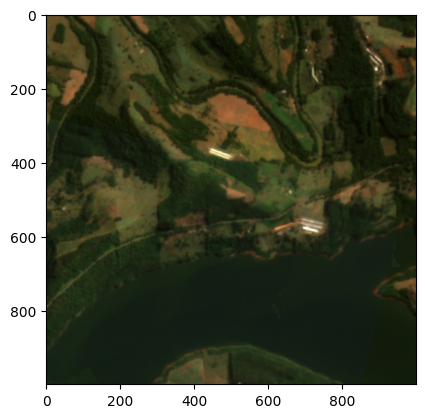

In [17]:
cloud_free_evalscript = """
var NODATA = 0;
var bands = ["red", "green", "blue"];

function setup() {
    return {
        input: bands.concat(["clear", "dataMask"]),
        output: {
            bands: bands.length,
            sampleType: "UINT16",
            nodataValue: NODATA
        },
        mosaicking: "TILE"
    };
}

function getFirstQuartileValue(values) {
    values.sort((a,b) => a-b);
    return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
    var index = Math.floor(sortedValues.length / 4);
    return sortedValues[index];
}

function evaluatePixel(samples) {
    // Initialize one array for each band where valid
    // samples will be saved
    var validSamples = {};
    for(let i=0; i<bands.length; i++){
        validSamples[bands[i]] = [];
    }
    // Loop through all samples
    for(let i=0; i<samples.length; i++){
        let sample = samples[i];
        // Check if the sample is valid
        if(!sample.dataMask || !sample.clear){
            // continue to the next sample if not valid
            continue;
        }
        // Push valid samples to respective arrays
        for(let i=0; i<bands.length; i++){
            validSamples[bands[i]].push(sample[bands[i]]);
        }
    }

    // Check if there is any valid samples
    if(validSamples[bands[0]].length==0){
        var outNodata = [];
        for(let i=0; i<bands.length; i++){
            outNodata.push(NODATA);
        }
        return outNodata
    }

    // Take the first quartile value in each of the bands
    var compositePixel = new Array(bands.length);
    for(let i=0; i<bands.length; i++){
        const validBandValues = validSamples[bands[i]]
        const firstQuartile = getFirstQuartileValue(validBandValues)
        compositePixel[i] = firstQuartile;
    }
    return compositePixel;
}
"""
cloud_free_data = request_helper(
    cloud_free_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(cloud_free_data[0] / 2000);

This looks like a nice cloud free composite.

### Exercise: Cloud Free False Color Composite 

This exercise should be quite easy. Try to modify the above script to return a false color composite.  
Hint: a False Color Composite is usually `["nir", "red", "green"]` 

<details><summary>See solution</summary>

```js
var NODATA = 0;
var bands = ["nir", "red", "green"];

function setup() {
    return {
        input: bands.concat(["clear", "dataMask"]),
        output: {
            bands: bands.length,
            sampleType: "UINT16",
            nodataValue: NODATA
        },
        mosaicking: "TILE"
    };
}

function getFirstQuartileValue(values) {
    values.sort((a,b) => a-b);
    return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
    var index = Math.floor(sortedValues.length / 4);
    return sortedValues[index];
}

function evaluatePixel(samples) {
    // Initialize one array for each band where valid
    // samples will be saved
    var validSamples = {};
    for(let i=0; i<bands.length; i++){
        validSamples[bands[i]] = [];
    }
    // Loop through all samples
    for(let i=0; i<samples.length; i++){
        let sample = samples[i];
        // Check if the sample is valid
        if(!sample.dataMask || !sample.clear){
            // continue to the next sample if not valid
            continue;
        }
        // Push valid samples to respective arrays
        for(let i=0; i<bands.length; i++){
            validSamples[bands[i]].push(sample[bands[i]]);
        }
    }

    // Check if there is any valid samples
    if(validSamples[bands[0]].length==0){
        var outNodata = [];
        for(let i=0; i<bands.length; i++){
            outNodata.push(NODATA);
        }
        return outNodata
    }

    // Take the first quartile value in each of the bands
    var compositePixel = new Array(bands.length);
    for(let i=0; i<bands.length; i++){
        const validBandValues = validSamples[bands[i]]
        const firstQuartile = getFirstQuartileValue(validBandValues)
        compositePixel[i] = firstQuartile;
    }
    return compositePixel;
}
```
</details>


In [18]:
fc_composite_evalscript = """

"""
fc_composite_data = request_helper(
    fc_composite_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(fc_composite_data[0] / 2000);

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/process
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/api/v1/process
Server response: "{"status": 400, "reason": "Bad Request", "message": "Missing or empty evalscript.", "code": "RENDERER_EXCEPTION"}"

Finally let's look at the case where we are only interested in very specific dates in our time of interest. A common case for that is change detection. For example the difference of NDVI between two dates.

## Temporal Change Detection: NDVI difference

In this analysis we want to look at the difference between two hand picked days: one in the beginning of May 2022 and the other end of April 2023. To do this we have to set the time range to an entire year (2022-05-01 to 2023-05-01). However we are only interested in two days in all of this data. To reduce the amount of data transmitted to the `evaluatePixel` function (and thus also the associated PU cost) we can use the function `preProcessScenes`.

This function runs before `evaluatePixel` and after `setup`. It has one parameter usually called `collections`. This parameter has a very similiar structure to `scenes` in `evaluatePixel` but let's have a closer look:

In [19]:
collections_evalscript = """
function setup() {
    return {
        input: ["red", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}

function preProcessScenes(collections){
    throw new Error(JSON.stringify(collections.scenes.tiles))
}

function evaluatePixel(samples) {
    return
}
"""
try:
    request_helper(
        collections_evalscript, start_date="2023-04-01", end_date="2023-04-10"
    )
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    scenes = json.loads(em[em.index("[") : em.index("]") + 1])
    pprint(scenes)

[{'__idx': 0,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230409_124434_67_24b2/20230409_124434_67_24b2_(BAND).tif',
  'date': '2023-04-09T12:44:34.676786Z',
  'shId': 17725313,
  'tileOriginalId': '03fb15c5-4b00-4057-b94b-be892549c2de'},
 {'__idx': 1,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230408_132106_91_2424/20230408_132106_91_2424_(BAND).tif',
  'date': '2023-04-08T13:21:06.919183Z',
  'shId': 17805766,
  'tileOriginalId': 'e45f6c0a-beff-4561-80a2-291975e8b5c5'},
 {'__idx': 2,
  'dataPath': 's3://sh.subscriptions.byoc.eu-central-1/28eef896-9632-4546-a99e-cea34d74b21e/c694b9a4-e5e0-4726-91aa-bfc89e9b7e10/20230405_133118_12_2402/20230405_133118_12_2402_(BAND).tif',
  'date': '2023-04-05T13:31:18.122270Z',
  'shId': 17733009,
  'tileOriginalId': 'd30393d1-b767-446d-ae02-935ef965c103'},
 {'__idx': 3,
  'dataP

We can see that collections holds similiar data to `scenes`. However you access that data with `collections.scenes.tiles` when `mosaicking: "TILES"` and with `collections.scenes.orbits` when `mosaicking: "ORBIT"`.

You can think of `preProcessScenes` as doing a catalog request just to see what kind of tiles are available in your area and time of interest. You can then modify the list to exclude certain elements. In the end the modified collections object is returned in the `preProcessScenes` function and only those tiles which are included in that collections object will get requested and passed to the `evaluatePixel` function.

So in our case we want to request exactly two dates. This can be done with this function:

```js
function preProcessScenes (collections) {
    var allowedDates = ["2022-05-08", "2023-04-30"];
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    })
    return collections
}
```

Here we will actually switch to `mosaicking: ORBIT` because we only want a single value per day. Let's see what the output of our filtering is:

In [20]:
collections_evalscript = """
function setup() {
    return {
        input: ["red", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function preProcessScenes (collections) {
    var allowedDates = ["2022-05-08", "2023-04-30"];
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    })
    throw new Error(JSON.stringify(collections.scenes.orbits))
    return collections
}

function evaluatePixel(samples) {
    return
}
"""
try:
    request_helper(
        collections_evalscript, start_date="2022-04-01", end_date="2023-05-01"
    )
except DownloadFailedException as e:
    test = e
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    scenes = json.loads(em[em.index("[{") : em.index("}]") + 2])
    pprint(scenes)

[{'__idx': 1,
  'dateFrom': '2023-04-30T00:00:00Z',
  'dateTo': '2023-04-30T23:59:59Z',
  'tiles': []},
 {'__idx': 261,
  'dateFrom': '2022-05-08T00:00:00Z',
  'dateTo': '2022-05-08T23:59:59Z',
  'tiles': []}]


Looking good! We reduced the list of all tiles down to only two, which are the two dates we selected. Now we can get to the analysis in the `evaluatePixel` function.

In it, we just calculate the NDVI for both dates and subtract the NDVI value of the old image from the NDVI value of the new image and return this value. Again we also check for missing values.

```js
function evaluatePixel(samples) {
    let old = samples[1];
    let recent = samples[0];
    if( !old.dataMask || !old.clear || !recent.dataMask || !recent.clear ){
        return [NODATA]
    }
    let difference = index(recent.nir, recent.red) - index(old.nir, old.red);
    return [difference]
}
```

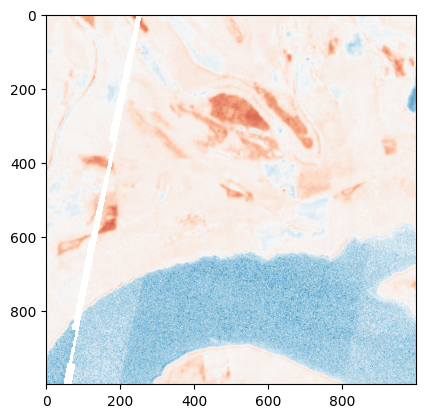

In [21]:
ndvi_diff_evalscript = """
var NODATA = NaN;

function setup() {
    return {
        input: ["nir", "red", "clear", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
            nodataValue: NODATA
        },
        mosaicking: "ORBIT"
    };
}

function preProcessScenes (collections) {
    var allowedDates = ["2022-05-08", "2023-04-30"];
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    })
    return collections
}

function evaluatePixel(samples) {
    let old = samples[1];
    let recent = samples[0];
    if( !old.dataMask || !old.clear || !recent.dataMask || !recent.clear ){
        return [NODATA]
    }
    let difference = index(recent.nir, recent.red) - index(old.nir, old.red);
    return [difference]
}
"""
ndvi_diff_data = request_helper(
    ndvi_diff_evalscript, start_date="2022-04-01", end_date="2023-05-01"
)
plt.imshow(ndvi_diff_data[0], cmap="RdBu", vmin=-1.0, vmax=1.0);

Here we can see pixels with lower NDVI in 2023 in red and with higher NDVI in blue. We also have a strip of missing data which we nicely handled with our edge case check.

The `preProcessScenes` function is quite powerful and can subset the returned tiles in a wide variety of ways. For more examples see the [documentation](https://docs.sentinel-hub.com/api/latest/evalscript/v3/#preprocessscenes-function-optional).

## Summary

In this notebook we've learned about the mosaicking options `SIMPLE`, `TILE` and `ORBIT` and what their differences are. We've learned how to access the `samples` object in `evaluatePixel` when doing multi-temporal analysis. In terms of analysis we've seen how to do cloud-free mosaics, maximum and mean NDVI composites and temporal NDVI differences.

For more multi-temporal evalscripts check out these examples on the custom script page:

- [Soil Water Content Anomaly](https://custom-scripts.sentinel-hub.com/planetary-variables/soil-water-content/soil-water-content-anomaly/)
- [Snow Cover Change Detection](https://custom-scripts.sentinel-hub.com/sentinel-2/snow_cover_change/)
- [Forest Cut Detection](https://custom-scripts.sentinel-hub.com/sentinel-2/forest_cut_temporal_detection/)
- [Vegetation Condition Index](https://custom-scripts.sentinel-hub.com/sentinel-2/vegetation_condition_index/)